In [2]:
import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

p = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [3]:

def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye


def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/totalmaindata.csv',sep=',')
#df = df.drop(df.columns[0],axis=1)

train_percentage = 17/22
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

df_train = df[:train_index]
df_test = df[-test_index:]

X_test = df_test.drop(["Y"],axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y',axis=1)
y_train = df_train['Y']

In [5]:
df = pd.read_csv('/content/drive/MyDrive/totalmaindata.csv',sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  # form a binary problem, delete the 5.0 ones
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 14/18 # based on max uniq. participants
train_samples = int(len(df) * train_percentage)
test_samples = len(df) - train_samples

df_train = df[:train_samples]
df_test = df[-test_samples:]

X_test = df_test.drop(["Y"], axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y', axis=1)
y_train = df_train['Y']
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape} \nX_train: {X_train.shape} \ny_train: {y_train.shape}')
df_train

X_test: (1920, 8) 
y_test: (1920,) 
X_train: (6720, 8) 
y_train: (6720,)


,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
9595,1,3.516036,0.308254,1.083833,0.440628,-3.087456,3.700493,-1.776452,4.040717
9596,1,3.585545,0.301381,1.080614,0.447949,-3.694883,3.646635,-1.472575,4.322363
9597,1,3.750118,0.286855,1.075740,0.450278,-4.978551,3.565087,-1.375905,4.989206
9598,1,4.123695,0.260188,1.072936,0.403545,-7.335156,3.518178,-3.315660,6.502924


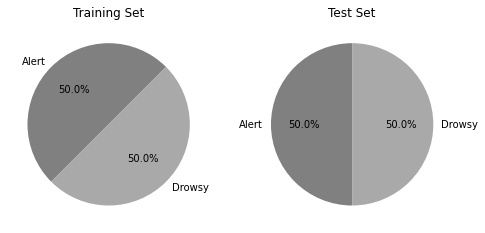

In [6]:
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [7]:
#KNN classifier
def average(y_pred):
    """Averaging sequential frames for classifier"""
    for i in range(len(y_pred)-1):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] + y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

acc3_list = []
f1_score3_list = []
roc_3_list = []

# take 45 runs and save best one
for i in range(1, 45):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
print(f"Neighbors: {neigh.get_params()['n_neighbors']}")
neigh.fit(X_train, y_train)
acc3 = accuracy_score(y_test, pred_KN)
print(acc3)

Neighbors: 38
0.6963541666666667
